In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

/u/kazumak2/.conda/envs/pytorch-env/lib/python3.9/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/zero-shot'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import create_sliding_windows, SequentialDeepONetDataset
from helper import load_model_experiment, convert2dim, train_val_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
#------------------------------
# Load model
#------------------------------
model_path = 'single_branch/lstm_window_30.pth'

model = load_model_experiment(model_path).to(device)

print(model)

Loaded model from single_branch/lstm_window_30.pth
SequentialDeepONet(
  (branch_net): LSTM(
    (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)


In [4]:
#------------------------------
# Load test input function (unseen 2023 data)
# Load test target (resolution 1 deg)
#------------------------------
input_sensor = np.load('data/neutron_data_22yrs.npy')

# 1 degree target
output_1deg = np.load('data/dose_array.npy')

# 0.25 degree target
output_025deg = np.load('data/DoseNumpy025/dose_2001_2023_0m.npy')

In [5]:
# data splitting keeping the consistency with training phase
train_input_1, train_target_1, val_input_1, val_target_1, test_input_1, test_target_1 = train_val_test_split(input_sensor, output_1deg)
train_input_025, train_target_025, val_input_025, val_target_025, test_input_025, test_target_025 = train_val_test_split(input_sensor, output_025deg)

# remove output_1deg and output_025deg from memory
del output_1deg
del output_025deg

Train input shape: (4017, 12)
Validation input shape: (4018, 12)
Test input shape: (365, 12)
Train input shape: (4017, 12)
Validation input shape: (4018, 12)
Test input shape: (365, 12)


In [6]:
# input scaler
scaler = MinMaxScaler()

# the input data is common for both 1 deg and 0.25 deg targets
# so we fit the scaler only once using train_input_1
dummy = scaler.fit_transform(train_input_1)
test_input_1 = scaler.transform(test_input_1)
test_input_025 = scaler.transform(test_input_025)

# target data normalization (min-max scaling)
scaler_target_1 = MinMaxScaler()
train_target_1 = scaler_target_1.fit_transform(train_target_1)[..., np.newaxis]
test_target_1 = scaler_target_1.transform(test_target_1)[..., np.newaxis]

scaler_target_025 = MinMaxScaler()
train_target_025 = scaler_target_025.fit_transform(train_target_025)[..., np.newaxis]
test_target_025 = scaler_target_025.transform(test_target_025)[..., np.newaxis]

In [7]:
# location points for 1 degree target
trunk_1deg = np.load('data/grid_points.npy')
trunk_025deg = np.load('data/grid_points_025.npy')

print('location range (1 deg):', np.min(trunk_1deg[:,0]), np.max(trunk_1deg[:,0]), np.min(trunk_1deg[:,1]), np.max(trunk_1deg[:,1]))
print('location range (0.25 deg):', np.min(trunk_025deg[:,0]), np.max(trunk_025deg[:,0]), np.min(trunk_025deg[:,1]), np.max(trunk_025deg[:,1]))

# Normalize trunk input
trunk_1deg[:, 0] = (trunk_1deg[:, 0] - np.min(trunk_1deg[:, 0])) / (np.max(trunk_1deg[:, 0]) - np.min(trunk_1deg[:, 0]))
trunk_1deg[:, 1] = (trunk_1deg[:, 1] - np.min(trunk_1deg[:, 1])) / (np.max(trunk_1deg[:, 1]) - np.min(trunk_1deg[:, 1]))

trunk_025deg[:, 0] = (trunk_025deg[:, 0] - np.min(trunk_025deg[:, 0])) / (np.max(trunk_025deg[:, 0]) - np.min(trunk_025deg[:, 0]))
trunk_025deg[:, 1] = (trunk_025deg[:, 1] - np.min(trunk_025deg[:, 1])) / (np.max(trunk_025deg[:, 1]) - np.min(trunk_025deg[:, 1]))

location range (1 deg): -90.0 90.0 -180.0 180.0
location range (0.25 deg): -90.0 90.0 -180.0 180.0


In [8]:
# Generate sequences for the testing set
test_input_seq_1, test_target_seq_1 = create_sliding_windows(test_input_1, test_target_1, window_size=30)

print('test_input_seq shape:', test_input_seq_1.shape)
print('test_target_seq shape:', test_target_seq_1.shape)

test_input_seq_025, test_target_seq_025 = create_sliding_windows(test_input_025, test_target_025, window_size=30)

print('test_input_seq_025 shape:', test_input_seq_025.shape)
print('test_target_seq_025 shape:', test_target_seq_025.shape)

test_input_seq shape: torch.Size([336, 30, 12])
test_target_seq shape: torch.Size([336, 65341, 1])
test_input_seq_025 shape: torch.Size([336, 30, 12])
test_target_seq_025 shape: torch.Size([336, 1038961, 1])


In [9]:
# Create DataLoader for test set
test_dataset_1 = SequentialDeepONetDataset(test_input_seq_1, trunk_1deg, test_target_seq_1)
test_loader_1 = DataLoader(test_dataset_1, batch_size=1, shuffle=False)

test_dataset_025 = SequentialDeepONetDataset(test_input_seq_025, trunk_025deg, test_target_seq_025)
test_loader_025 = DataLoader(test_dataset_025, batch_size=1, shuffle=False)

In [10]:
def fit(model, data_loader, device, scaler_target):
    all_outputs = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for branch_batch, trunk_batch, target_batch in data_loader:
            branch_batch, trunk_batch, target_batch = (
                branch_batch.to(device),
                trunk_batch.to(device),
                target_batch.to(device),
            )
            output = model(branch_batch, trunk_batch)
            
            all_outputs.append(output.cpu())
            all_targets.append(target_batch.cpu())

    # ...existing code...
    # After loop:
    outputs = torch.cat(all_outputs, dim=0)  # [N_test, ...]
    targets = torch.cat(all_targets, dim=0)  # [N_test, ...]

    # move to numpy
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()

    # flatten to 2D (n_samples, n_features) for scaler
    out_shape = outputs.shape
    tgt_shape = targets.shape
    outputs_flat = outputs.reshape(outputs.shape[0], -1)
    targets_flat = targets.reshape(targets.shape[0], -1)

    # inverse scale
    outputs_flat = scaler_target.inverse_transform(outputs_flat)
    targets_flat = scaler_target.inverse_transform(targets_flat)

    # restore original shapes
    outputs = outputs_flat.reshape(out_shape)
    targets = targets_flat.reshape(tgt_shape)
    # ...existing code...

    
    return outputs, targets

In [11]:
predictions_1deg, targets_1deg = fit(model, test_loader_1, device, scaler_target_1)
print('predictions shape:', predictions_1deg.shape)
print('targets shape:', targets_1deg.shape)

predictions_025deg, targets_025deg = fit(model, test_loader_025, device, scaler_target_025)
print('predictions shape:', predictions_025deg.shape)
print('targets shape:', targets_025deg.shape)

predictions shape: (336, 65341, 1)
targets shape: (336, 65341, 1)
predictions shape: (336, 1038961, 1)
targets shape: (336, 1038961, 1)


In [12]:
lon_grid_1, lat_grid_1, pred_img_1 = convert2dim(predictions_1deg)  # (N,H,W)
_,        _,        targ_img_1 = convert2dim(targets_1deg)      # (N,H,W)

lon_grid_025, lat_grid_025, pred_img_025 = convert2dim(predictions_025deg, grid_path='data/grid_points_025.npy')  # (N,H,W)
_,          _,          targ_img_025 = convert2dim(targets_025deg, grid_path='data/grid_points_025.npy')      # (N,H,W)


# print pred sizes
print('1 deg pred_img shape:', pred_img_1.shape)
print('0.25 deg pred_img shape:', pred_img_025.shape)

print('1 deg targ_img shape:', targ_img_1.shape)
print('0.25 deg targ_img shape:', targ_img_025.shape)

1 deg pred_img shape: (336, 181, 361)
0.25 deg pred_img shape: (336, 721, 1441)
1 deg targ_img shape: (336, 181, 361)
0.25 deg targ_img shape: (336, 721, 1441)


In [13]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def compute_metrics(pred_img, targ_img):
    ''' 
    Compute and print evaluation metrics between predicted and target images.
    Both inputs should be numpy arrays of shape (N, H, W), where N is the number of samples.
    '''

    pred_img = pred_img.astype(np.float64)
    targ_img = targ_img.astype(np.float64)

    N = pred_img.shape[0]
    eps = 1e-12

    # ---- Relative L2 (%) per-sample + mean ----
    pf = pred_img.reshape(N, -1)
    tf = targ_img.reshape(N, -1)
    rel_l2_pct = 100.0 * np.linalg.norm(pf - tf, axis=1) / (np.linalg.norm(tf, axis=1) + eps)
    print("Mean Relative L2 (%):", rel_l2_pct.mean())

    # ---- SSIM per-sample + mean (uses target’s per-sample dynamic range) ----
    ssim_scores = np.empty(N, dtype=float)
    for i in range(N):
        dr = float(targ_img[i].max() - targ_img[i].min()) or 1.0
        ssim_scores[i] = ssim(targ_img[i], pred_img[i], data_range=dr)
    print("Mean SSIM:", ssim_scores.mean())
    
    return rel_l2_pct, ssim_scores

In [14]:
rel_l2_1deg, ssim_1deg = compute_metrics(pred_img_1, targ_img_1)
rel_l2_025deg, ssim_025deg = compute_metrics(pred_img_025, targ_img_025)

Mean Relative L2 (%): 0.11214224732374158
Mean SSIM: 0.9993264326744773
Mean Relative L2 (%): 0.11199571066941721
Mean SSIM: 0.9998753174204781


In [15]:
def compute_metrics_region(pred_img, targ_img, lon_grid, lat_grid, region_extent):
    """
    Compute rel-L2 and SSIM restricted to a spatial subset.
    region_extent = [lon_min, lon_max, lat_min, lat_max]
    pred_img, targ_img: arrays of shape (N, H, W)
    lon_grid, lat_grid: (H, W)
    """
    lon_min, lon_max, lat_min, lat_max = region_extent

    # Mask to select region
    mask_lat = (lat_grid[:, 0] >= lat_min) & (lat_grid[:, 0] <= lat_max)
    mask_lon = (lon_grid[0, :] >= lon_min) & (lon_grid[0, :] <= lon_max)

    # Subset fields
    pred_sub = pred_img[:, mask_lat, :][:, :, mask_lon]
    targ_sub = targ_img[:, mask_lat, :][:, :, mask_lon]

    # Flatten spatial dims
    N = pred_sub.shape[0]
    eps = 1e-12
    pf = pred_sub.reshape(N, -1)
    tf = targ_sub.reshape(N, -1)

    # --- Relative L2 (%) ---
    rel_l2_pct = 100.0 * np.linalg.norm(pf - tf, axis=1) / (np.linalg.norm(tf, axis=1) + eps)

    # --- SSIM ---
    ssim_scores = np.empty(N, dtype=float)
    for i in range(N):
        dr = float(targ_sub[i].max() - targ_sub[i].min()) or 1.0
        ssim_scores[i] = ssim(targ_sub[i], pred_sub[i], data_range=dr)

    print(f"Region {region_extent}")
    print("Mean rel-L2 (%):", rel_l2_pct.mean())
    print("Mean SSIM:", ssim_scores.mean())
    
    return rel_l2_pct, ssim_scores


In [16]:
import pandas as pd

def make_sequence_windows(year: int, seq_len: int = 30, leap: bool = True):
    """
    Create sequence window metadata for EXPACS daily data,
    where target_date == end_date (same-day prediction).

    Parameters
    ----------
    year : int
        Target simulation year (e.g., 2023)
    seq_len : int, optional
        Number of days per input sequence (default: 30)
    leap : bool, optional
        Whether to include Feb 29 in leap years (default: True)

    Returns
    -------
    windows : pd.DataFrame
        Columns:
          - 'start_date': first day of input sequence
          - 'end_date': last day of input sequence (== target)
          - 'target_date': same as end_date
          - 'index': sequential integer index (0, 1, 2, …)
    """

    # Determine number of days in this year
    n_days = 366 if (leap and pd.Timestamp(year=year, month=12, day=31).is_leap_year) else 365

    # Build full daily timeline
    dates = pd.date_range(f"{year}-01-01", periods=n_days, freq="D")

    start_dates, end_dates, target_dates = [], [], []

    # Sliding windows
    for i in range(seq_len - 1, n_days):
        start_dates.append(dates[i - seq_len + 1])
        end_dates.append(dates[i])
        target_dates.append(dates[i])   # same as end_date

    df = pd.DataFrame({
        "index": range(len(target_dates)),
        "start_date": start_dates,
        "end_date": end_dates,
        "target_date": target_dates
    })

    return df


# =============================
# Example usage
# =============================
year = 2023
seq_len = 30
meta = make_sequence_windows(year, seq_len)

print(meta.head(5))
print(f"\nTotal windows: {len(meta)}")


   index start_date   end_date target_date
0      0 2023-01-01 2023-01-30  2023-01-30
1      1 2023-01-02 2023-01-31  2023-01-31
2      2 2023-01-03 2023-02-01  2023-02-01
3      3 2023-01-04 2023-02-02  2023-02-02
4      4 2023-01-05 2023-02-03  2023-02-03

Total windows: 336


In [17]:
year = 2023
seq_len = 30
meta = make_sequence_windows(year, seq_len)

print(meta.head())

target_date = meta['target_date'].to_numpy()

   index start_date   end_date target_date
0      0 2023-01-01 2023-01-30  2023-01-30
1      1 2023-01-02 2023-01-31  2023-01-31
2      2 2023-01-03 2023-02-01  2023-02-01
3      3 2023-01-04 2023-02-02  2023-02-02
4      4 2023-01-05 2023-02-03  2023-02-03


Median L2 (1°): 0.10560853500629194
Date: 2023-05-19T00:00:00.000000000


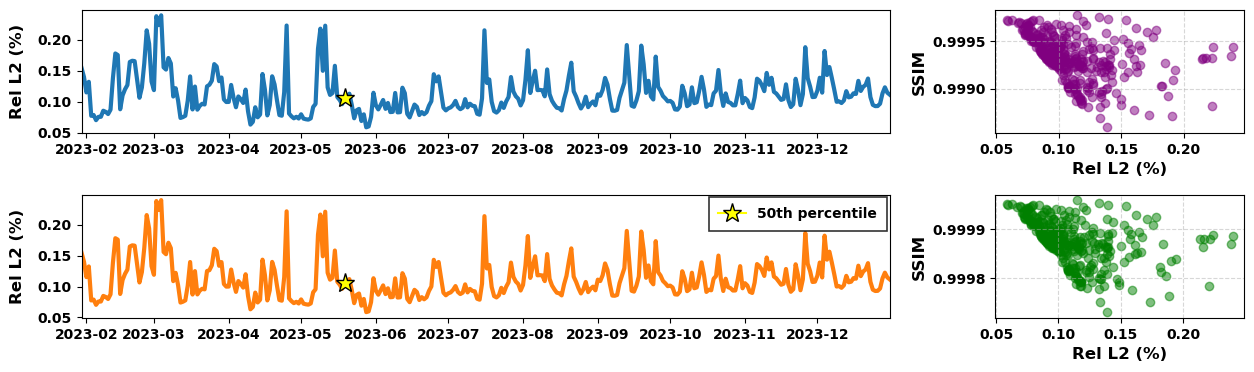

In [50]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import numpy as np

# --- Compute 50th percentile and corresponding date ---
rel_l2_1deg_50pct = np.percentile(rel_l2_1deg, 50)
idx_50pct_1deg = np.argmin(np.abs(rel_l2_1deg - rel_l2_1deg_50pct))
date_50pct_1deg = target_date[idx_50pct_1deg]
print("Median L2 (1°):", rel_l2_1deg_50pct)
print("Date:", date_50pct_1deg)

# --- Create figure ---
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(
    2, 4, figure=fig,
    width_ratios=[10, 1, 1, 5],
    height_ratios=[1, 1],
    wspace=0.5, hspace=0.5
)

fontsize = 12

# =====================================================
# Row 1: 1° data (top)
# =====================================================
ax1 = fig.add_subplot(gs[0, 0:3])
ax1.set_ylabel('Rel L2 (%)', fontweight='bold', fontsize=fontsize)
line1, = ax1.plot(target_date, rel_l2_1deg, color='tab:blue', linewidth=3)
ax1.set_xlim([target_date[0], target_date[-1]])

# Add yellow star marker for 50th percentile
star1, = ax1.plot(date_50pct_1deg, rel_l2_1deg[idx_50pct_1deg],
                  marker='*', color='yellow', markersize=14,
                  markeredgecolor='black', label='50th percentile')

ax2 = fig.add_subplot(gs[0, 3])
ax2.scatter(rel_l2_1deg, ssim_1deg, color='purple', alpha=0.5)
ax2.set_xlabel("Rel L2 (%)", fontweight='bold', fontsize=fontsize)
ax2.set_ylabel("SSIM", fontweight='bold', fontsize=fontsize)

# =====================================================
# Row 2: 0.25° data (bottom)
# =====================================================
ax3 = fig.add_subplot(gs[1, 0:3])
ax3.set_ylabel('Rel L2 (%)', fontweight='bold', fontsize=fontsize)
line2, = ax3.plot(target_date, rel_l2_025deg, color='tab:orange', linewidth=3)
ax3.set_xlim([target_date[0], target_date[-1]])

# Add yellow star marker at same date (nearest match)
idx_50pct_025deg = np.argmin(np.abs(target_date - date_50pct_1deg))
star2, = ax3.plot(date_50pct_1deg, rel_l2_025deg[idx_50pct_025deg],
                  marker='*', color='yellow', markersize=14,
                  markeredgecolor='black', label='50th percentile')

ax4 = fig.add_subplot(gs[1, 3])
ax4.scatter(rel_l2_025deg, ssim_025deg, color='green', alpha=0.5)
ax4.set_xlabel("Rel L2 (%)", fontweight='bold', fontsize=fontsize)
ax4.set_ylabel("SSIM", fontweight='bold', fontsize=fontsize)

# =====================================================
# Formatting
# =====================================================
# Tick formatting
for ax in [ax1, ax3]:
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

for ax in [ax2, ax4]:
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.grid(True, linestyle='--', alpha=0.5)

# Make all tick labels bold
for ax in [ax1, ax2, ax3, ax4]:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

# Align y-labels in first column
ax1.yaxis.set_label_coords(-0.07, 0.5)
ax3.yaxis.set_label_coords(-0.07, 0.5)


# Filter out any automatically generated artists
handles = [h for h in [line2, star2] if not h.get_label().startswith('_')]

legend2 = ax3.legend(handles=handles,
                     frameon=True,
                     edgecolor='black',
                     facecolor='none',
                     fontsize=10,
                     loc='upper right')

# Make legend text bold and border a bit thicker
for text in legend2.get_texts():
    text.set_fontweight('bold')
legend2.get_frame().set_linewidth(1.2)
legend2.get_frame().set_boxstyle('Square')

plt.savefig('analysis/zero-shot/relL2_ssim_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# for plotting setting
Lon025 = lon_grid_025
Lat025 = lat_grid_025
field025 = pred_img_025
error025 = np.abs(targ_img_025 - pred_img_025)

# 1 degree
Lon1 = lon_grid_1
Lat1 = lat_grid_1
field1 = pred_img_1
error1 = np.abs(targ_img_1 - pred_img_1)

In [20]:
from helper import plot_field_region
import cmocean
cmap_seq = cmocean.cm.thermal

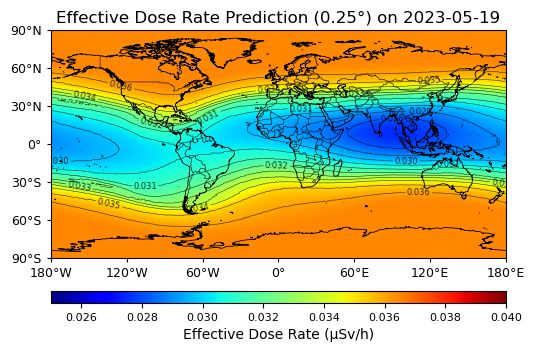

<Figure size 600x300 with 0 Axes>

In [51]:
# day index
day = idx_50pct_1deg


plot_field_region(
    Lon025, Lat025, field025, i=day,
    title=f"Effective Dose Rate Prediction (0.25°) on {pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 20),
    mark_equator_meridian=False,
    cmap= 'jet',
    #savepath='analysis/zero-shot/prediction_025deg_global.png'
)
plt.gcf().set_size_inches(6, 3)


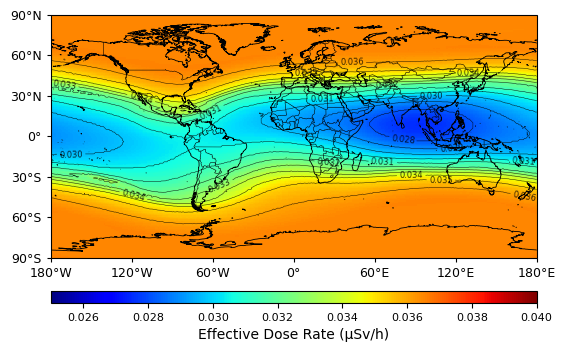

<Figure size 600x300 with 0 Axes>

In [49]:
plot_field_region(
    Lon1, Lat1, field1, i=day,
    #title=f"Effective Dose Rate Prediction (1°) on {pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 20),
    mark_equator_meridian=False,
    cmap= 'jet',
    #savepath='analysis/zero-shot/prediction_1deg_global.png'
)
plt.gcf().set_size_inches(6, 3)


Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.12544195
Mean SSIM: 0.9997386906662241
Rel L2 (%) in region: 0.10182865
SSIM in region: 0.9998115370750684


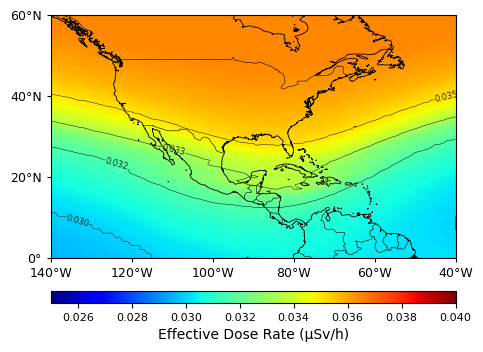

<Figure size 600x300 with 0 Axes>

In [42]:
region_extent = [-140, -40, 0, 60]  # e.g., South Atlantic region

# compute metrics in the specified region
rel_l2_025, ssim_score_025 = compute_metrics_region(
    pred_img_025, targ_img_025, lon_grid_025, lat_grid_025, region_extent
)

print("Rel L2 (%) in region:", rel_l2_025[day])
print("SSIM in region:", ssim_score_025[day])

# plot in the specified region
plot_field_region(
    Lon025, Lat025, field025, i=day,
    #title=f"Effective Dose Rate Prediction (0.25°) on {pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=region_extent,
    vmin=0.025, vmax=0.040,
    tick_step=(20, 20),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    cmap= 'jet',
    #savepath='analysis/zero-shot/prediction_025deg_region.png'
)
plt.gcf().set_size_inches(6, 3)


Region [-140, -40, 0, 60]
Mean rel-L2 (%): 0.12522905
Mean SSIM: 0.9986667127599
Rel L2 (%) in region: 0.10142128
SSIM in region: 0.999226367758792


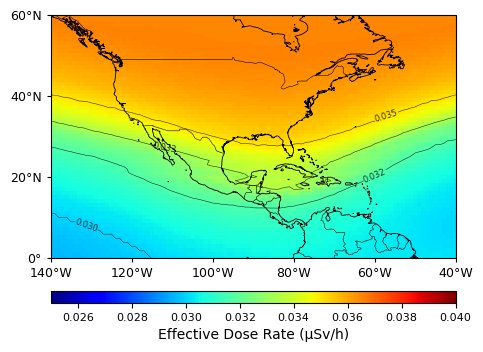

<Figure size 600x300 with 0 Axes>

In [43]:
# compute metrics in the specified region
rel_l2_1, ssim_score_1 = compute_metrics_region(
    pred_img_1, targ_img_1, lon_grid_1, lat_grid_1, region_extent
)

print("Rel L2 (%) in region:", rel_l2_1[day])
print("SSIM in region:", ssim_score_1[day])

# plot in the specified region
plot_field_region(
    Lon1, Lat1, field1, i=day,
    #title=f"Effective Dose Rate Prediction (1°) on {pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=region_extent,
    vmin=0.025, vmax=0.040,
    tick_step=(20, 20),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    cmap= 'jet',
    #savepath='analysis/zero-shot/prediction_1deg_region.png'
)
plt.gcf().set_size_inches(6, 3)

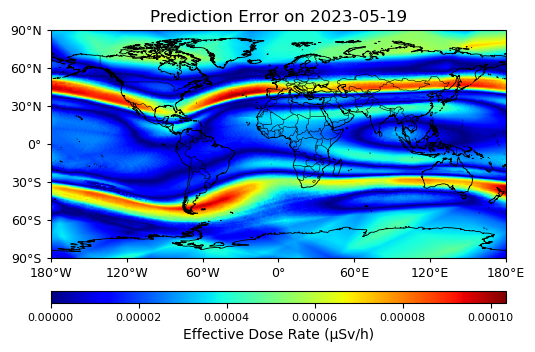

<Figure size 600x300 with 0 Axes>

In [25]:
plot_field_region(
    Lon025, Lat025, error025, i=day,
    title=f"Prediction Error on {pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    #vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 20),
    mark_equator_meridian=False,
    cmap= 'jet'
)
plt.gcf().set_size_inches(6, 3)

In [52]:
# plot in the specified region
plot_field_region(
    Lon025, Lat025, error025, i=day,
    #title=f"Prediction Error (0.25°) on {pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')}",
    units_label="Error Magnitude (µSv/h)",
    region_extent=region_extent,
    #vmin=0.025, vmax=0.040,
    tick_step=(20, 20),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    cmap= 'jet',
    savepath='analysis/zero-shot/prediction_error_025deg_region.png'
)
#plt.gcf().set_size_inches(6, 3)


In [53]:
# plot in the specified region
plot_field_region(
    Lon1, Lat1, error1, i=day,
    #title=f"Prediction Error (1°) on {pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')}",
    units_label="Error Magnitude (µSv/h)",
    region_extent=region_extent,
    #vmin=0.025, vmax=0.040,
    tick_step=(20, 20),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    cmap= 'jet',
    savepath='analysis/zero-shot/prediction_error_1deg_region.png'
)
#plt.gcf().set_size_inches(6, 3)


In [28]:
# mean + std (1 degree)
print("Rel L2 (%) in region:", rel_l2_1.mean(), "+/-", rel_l2_1.std())
print("SSIM in region:", ssim_score_1.mean(), "+/-", ssim_score_1.std())

# mean + std (0.25 degree)
print("Rel L2 (%) in region:", rel_l2_025.mean(), "+/-", rel_l2_025.std())
print("SSIM in region:", ssim_score_025.mean(), "+/-", ssim_score_025.std())

# daily 
print("Daily Rel L2 (%) in region (1°):", rel_l2_1[day])
print("Daily SSIM in region (1°):", ssim_score_1[day])

print("Daily Rel L2 (%) in region (0.25°):", rel_l2_025[day])
print("Daily SSIM in region (0.25°):", ssim_score_025[day])

Rel L2 (%) in region: 0.12522905 +/- 0.02570409
SSIM in region: 0.9986667127599 +/- 0.0004930340689412696
Rel L2 (%) in region: 0.12544195 +/- 0.02564286
SSIM in region: 0.9997386906662241 +/- 9.456457836857033e-05
Daily Rel L2 (%) in region (1°): 0.10142128
Daily SSIM in region (1°): 0.999226367758792
Daily Rel L2 (%) in region (0.25°): 0.10182865
Daily SSIM in region (0.25°): 0.9998115370750684


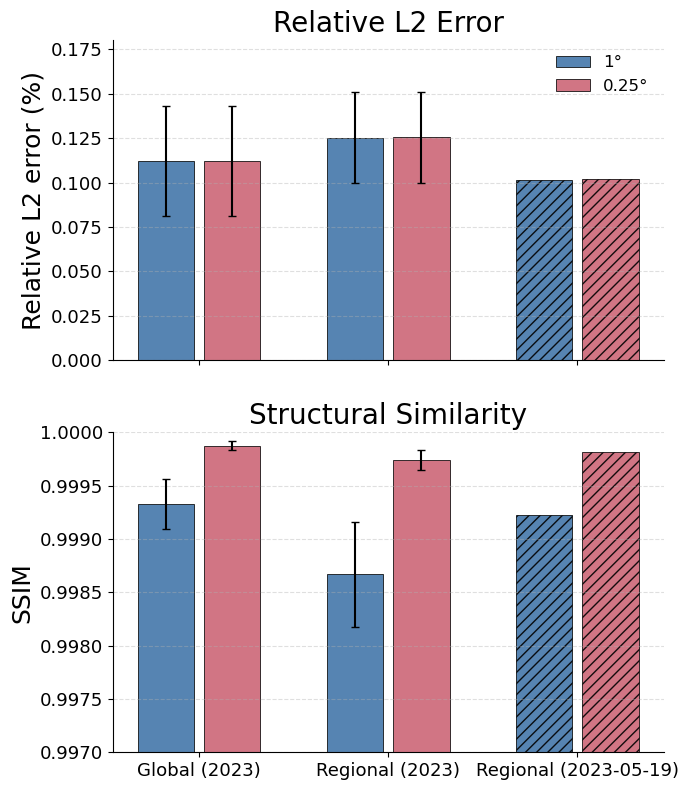

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Metric values (mean ± std where available)
# ===============================
# --- Global (1-year mean) ---
rel_l2_global_1,  std_l2_global_1  = rel_l2_1deg.mean(), rel_l2_1deg.std()
rel_l2_global_025, std_l2_global_025 = rel_l2_025deg.mean(), rel_l2_025deg.std()
ssim_global_1,  std_ssim_global_1  = ssim_1deg.mean(), ssim_1deg.std()
ssim_global_025, std_ssim_global_025 = ssim_025deg.mean(), ssim_025deg.std()

# --- Regional (1-year mean) ---
rel_l2_regional_1,  std_l2_regional_1  = rel_l2_1.mean(), rel_l2_1.std()
rel_l2_regional_025, std_l2_regional_025 = rel_l2_025.mean(), rel_l2_025.std()
ssim_regional_1,  std_ssim_regional_1  = ssim_score_1.mean(), ssim_score_1.std()
ssim_regional_025, std_ssim_regional_025 = ssim_score_025.mean(), ssim_score_025.std()

# --- Regional (specific day) ---
rel_l2_local_1 = rel_l2_1[day]
rel_l2_local_025 = rel_l2_025[day]
ssim_local_1 = ssim_score_1[day]
ssim_local_025 = ssim_score_025[day]

# ===============================
# Plot settings
# ===============================
labels = ['Global (2023)', 'Regional (2023)', f"Regional ({pd.to_datetime(target_date[day]).strftime('%Y-%m-%d')})"]
x = np.arange(len(labels))
bar_width = 0.3
gap = 0.05

# --- Improved color palette (scientific & colorblind safe) ---
color_1deg = '#4477AA'   # muted blue
color_025deg = '#CC6677' # warm salmon
hatch_style = '///'      # hatch pattern for Regional (Day)

# Create vertical subplots (2 rows, 1 column)
fig, axs = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# -------------------------------
# (a) Relative L2 Error (%)
# -------------------------------
vals_1deg = [rel_l2_global_1, rel_l2_regional_1, rel_l2_local_1]
vals_025deg = [rel_l2_global_025, rel_l2_regional_025, rel_l2_local_025]
std_1deg = [std_l2_global_1, std_l2_regional_1, 0]
std_025deg = [std_l2_global_025, std_l2_regional_025, 0]

for i in range(len(labels)):
    hatch = hatch_style if i == 2 else None
    axs[0].bar(x[i] - (bar_width/2 + gap/2), vals_1deg[i],
               width=bar_width, color=color_1deg, alpha=0.9, hatch=hatch,
               edgecolor='black', linewidth=0.6,
               yerr=None if std_1deg[i] == 0 else std_1deg[i],
               capsize=3 if std_1deg[i] != 0 else 0)
    axs[0].bar(x[i] + (bar_width/2 + gap/2), vals_025deg[i],
               width=bar_width, color=color_025deg, alpha=0.9, hatch=hatch,
               edgecolor='black', linewidth=0.6,
               yerr=None if std_025deg[i] == 0 else std_025deg[i],
               capsize=3 if std_025deg[i] != 0 else 0)

axs[0].set_ylabel('Relative L2 error (%)', fontsize=18)
axs[0].grid(axis='y', linestyle='--', alpha=0.4)
axs[0].legend(['1°', '0.25°'], frameon=False, loc='upper right', fontsize=12)
axs[0].set_ylim(0, 0.18)
axs[0].set_title('Relative L2 Error', fontsize=20, pad=6)
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, fontsize=15, rotation=10)

# -------------------------------
# (b) Structural Similarity (SSIM)
# -------------------------------
vals_1deg = [ssim_global_1, ssim_regional_1, ssim_local_1]
vals_025deg = [ssim_global_025, ssim_regional_025, ssim_local_025]
std_1deg = [std_ssim_global_1, std_ssim_regional_1, 0]
std_025deg = [std_ssim_global_025, std_ssim_regional_025, 0]

for i in range(len(labels)):
    hatch = hatch_style if i == 2 else None
    axs[1].bar(x[i] - (bar_width/2 + gap/2), vals_1deg[i],
               width=bar_width, color=color_1deg, alpha=0.9, hatch=hatch,
               edgecolor='black', linewidth=0.6,
               yerr=None if std_1deg[i] == 0 else std_1deg[i],
               capsize=3 if std_1deg[i] != 0 else 0)
    axs[1].bar(x[i] + (bar_width/2 + gap/2), vals_025deg[i],
               width=bar_width, color=color_025deg, alpha=0.9, hatch=hatch,
               edgecolor='black', linewidth=0.6,
               yerr=None if std_025deg[i] == 0 else std_025deg[i],
               capsize=3 if std_025deg[i] != 0 else 0)

axs[1].set_ylabel('SSIM', fontsize=18)
axs[1].grid(axis='y', linestyle='--', alpha=0.4)
axs[1].set_ylim(0.997, 1.0000)
axs[1].set_title('Structural Similarity', fontsize=20, pad=6)
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, fontsize=15)

# -------------------------------
# Final formatting
# -------------------------------
for ax in axs:
    ax.tick_params(axis='both', labelsize=13)
    ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout(h_pad=2.2)
plt.savefig('analysis/zero-shot/summary_metrics.png', dpi=300)
plt.show()
